In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
NEW_DATASET = os.path.join(DATA_FOLDER, 'final_dataset.csv')

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [4]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

n_neighbors = 20
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode='distance', p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [5]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"] / n_neighbors
    score[element] = mean_dist

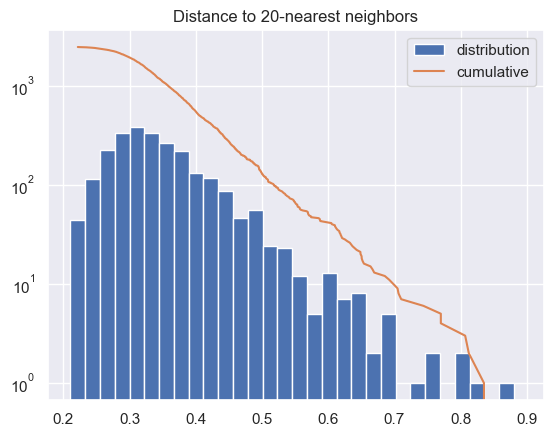

In [6]:
plt.hist(score, bins=30, align="left", label="distribution")
plt.plot(np.flip(np.sort(score)), np.linspace(0, len(df), len(df)), label="cumulative")
plt.yscale('log')
plt.title(f'Distance to {n_neighbors}-nearest neighbors')
plt.legend()
plt.show()

In [7]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)
print(embedding.shape)

(2452, 2)


66


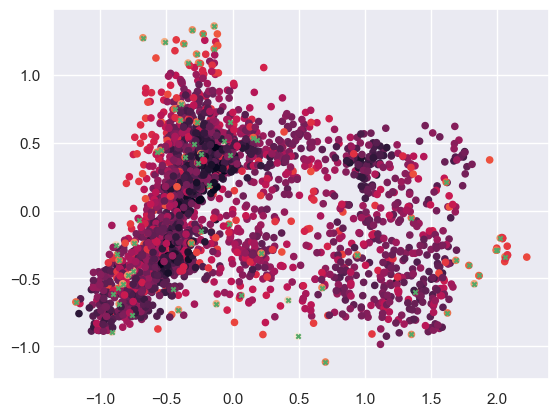

In [8]:
plt.scatter(*embedding.T, c=np.log10(score), s=20)
cutted = embedding[score > 0.55]
print(len(cutted))
plt.scatter(*cutted.T, marker="x", color="g", s=10)
plt.show()

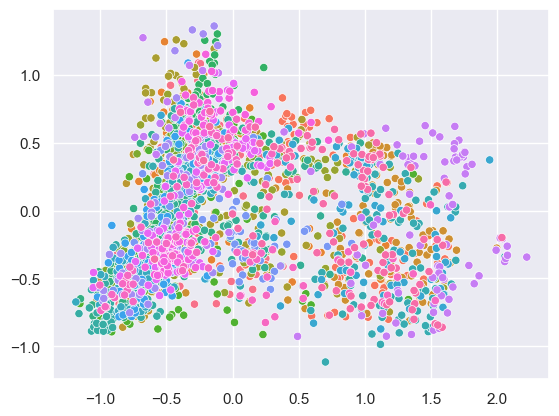

In [9]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['actor'], legend=False)
plt.show()

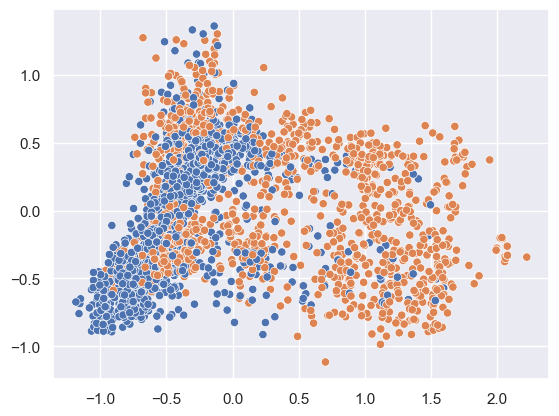

In [10]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

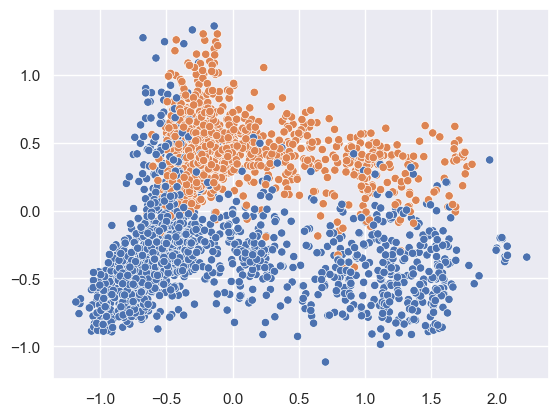

In [11]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)
plt.show()

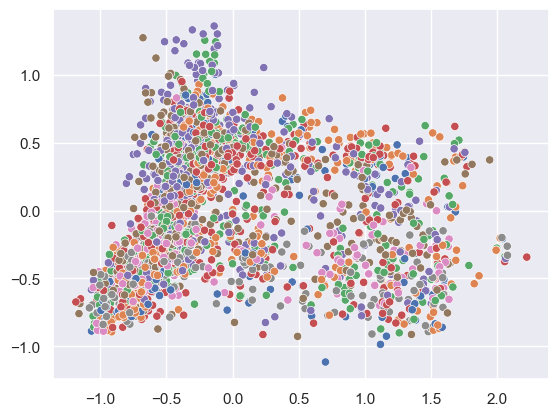

In [12]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)
plt.show()

## Ensemble-based Approach: Isolation forest

### Division of the dataset by categories: sex

In [13]:
df_sex_m = df[df['sex'] == 'M']
df_sex_f = df[df['sex'] == 'F']

In [14]:
scaler = MinMaxScaler()

X_sex_f = scaler.fit_transform(df_sex_f[numerical_attr_list])
X_sex_m = scaler.fit_transform(df_sex_m[numerical_attr_list])

In [15]:
embedding_sex_f = reducer.fit_transform(X_sex_f)
embedding_sex_m = reducer.fit_transform(X_sex_m)

In [16]:
def get_score(X):
    G = kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance', p=np.inf)
    G = nx.DiGraph(G)
    dictator = nx.to_dict_of_dicts(G)

    score = np.zeros(len(X))
    for element in dictator.keys():
        mean_dist = 0
        for child in dictator[element].keys():
            mean_dist += dictator[element][child]['weight'] / n_neighbors
        score[element] = mean_dist

    return score

In [17]:
score_sex_f = get_score(X_sex_f)
score_sex_m = get_score(X_sex_m)

### Isolation forest on F dataframe

In [18]:
from sklearn.ensemble import IsolationForest

isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_sex_f)

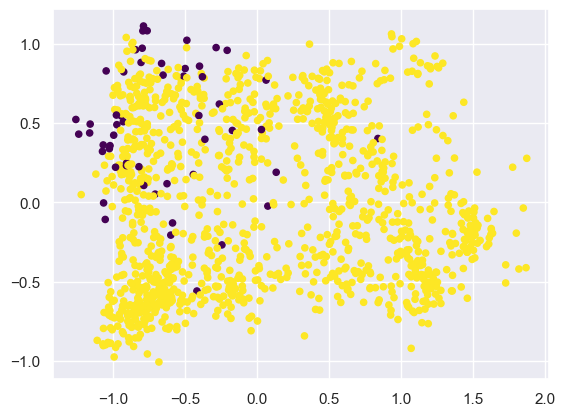

In [19]:
plt.scatter(*embedding_sex_f.T, c=outliers, s=20, cmap='viridis')
plt.show()

In [20]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  54, 1150]))

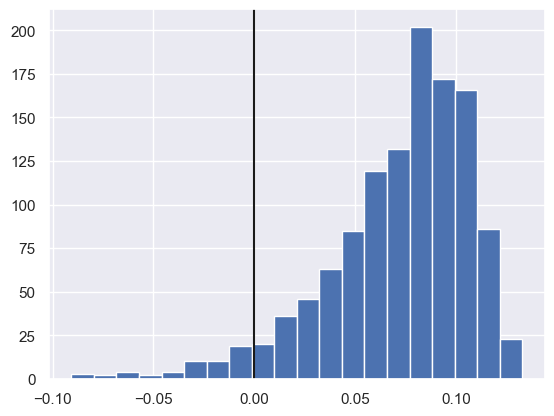

In [21]:
plt.hist(isfo.decision_function(X_sex_f), bins=20)
plt.axvline(np.min(isfo.decision_function(X_sex_f)[np.where(outliers == 1)]), c='k')
plt.show()

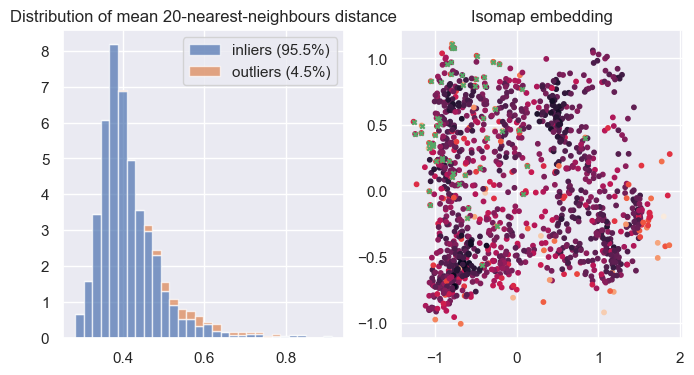

In [22]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8,4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest-neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_sex_f.T, c=np.log10(score_sex_f), s=10)
axscat.scatter(*embedding_sex_f[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_sex_f) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_sex_f) * 100:.1f}%)'
]

axhist.hist([score_sex_f[outliers == 1], score_sex_f[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [23]:
df_sex_f = df_sex_f.loc[outliers == 1]
df_sex_f.shape

(1150, 250)

### Isolation forest on M dataframe

In [24]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_sex_m)

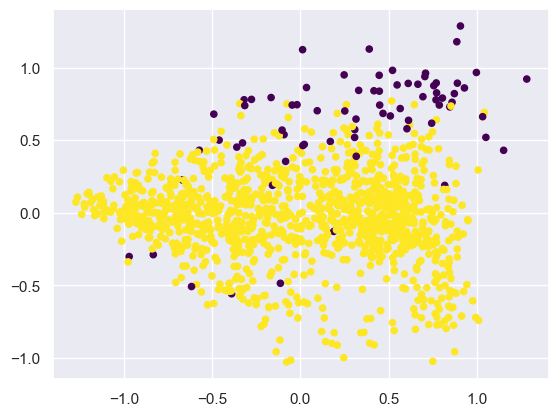

In [25]:
plt.scatter(*embedding_sex_m.T, c=outliers, s=20, cmap='viridis')
plt.show()

In [26]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  73, 1175]))

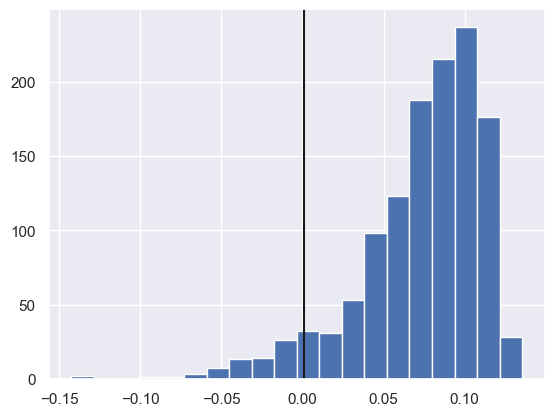

In [27]:
plt.hist(isfo.decision_function(X_sex_m), bins=20)
plt.axvline(np.min(isfo.decision_function(X_sex_m)[np.where(outliers == 1)]), c='k')
plt.show()

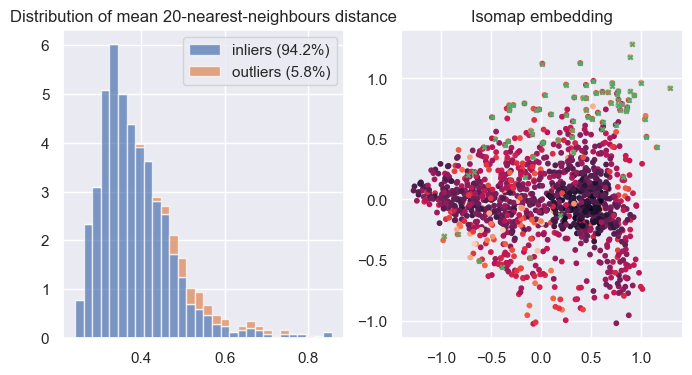

In [28]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8,4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest-neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_sex_m.T, c=np.log10(score_sex_m), s=10)
axscat.scatter(*embedding_sex_m[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_sex_m) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_sex_m) * 100:.1f}%)'
]

axhist.hist([score_sex_m[outliers == 1], score_sex_m[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [29]:
df_sex_m = df_sex_m.loc[outliers == 1]
df_sex_m.shape

(1175, 250)

### Elimination of the outliers found

In [30]:
# creates an index list by combining the indexes of the two dataframes
new_indexes = pd.Index(df_sex_f.index.tolist() + df_sex_m.index.tolist())

# keep just the new indexes
df = df.loc[new_indexes]
df.shape

(2325, 250)

### Division of the dataset by categories: vocal_channel

In [31]:
df_speech = df[df['vocal_channel'] == 'speech']
df_song = df[df['vocal_channel'] == 'song']

In [32]:
scaler = MinMaxScaler()

X_speech = scaler.fit_transform(df_speech[numerical_attr_list])
X_song = scaler.fit_transform(df_song[numerical_attr_list])

In [33]:
embedding_speech = reducer.fit_transform(X_speech)
embedding_song = reducer.fit_transform(X_song)

In [34]:
score_speech = get_score(X_speech)
score_song = get_score(X_song)

### Isolation forest on speech dataframe

In [35]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_speech)

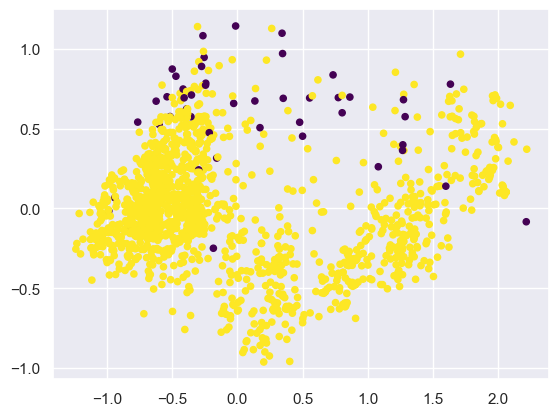

In [36]:
plt.scatter(*embedding_speech.T, c=outliers, s=20, cmap='viridis')
plt.show()

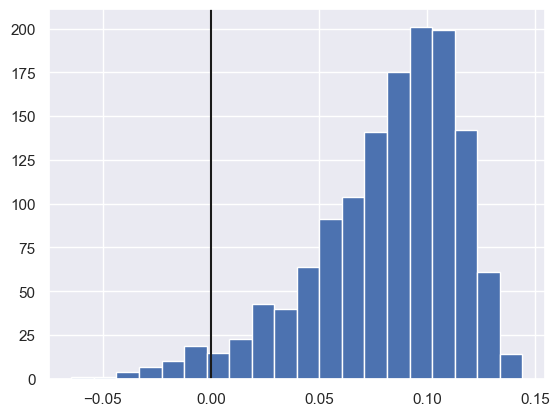

In [37]:
np.unique(outliers, return_counts=True)
plt.hist(isfo.decision_function(X_speech), bins=20)
plt.axvline(np.min(isfo.decision_function(X_speech)[np.where(outliers == 1)]), c='k')
plt.show()

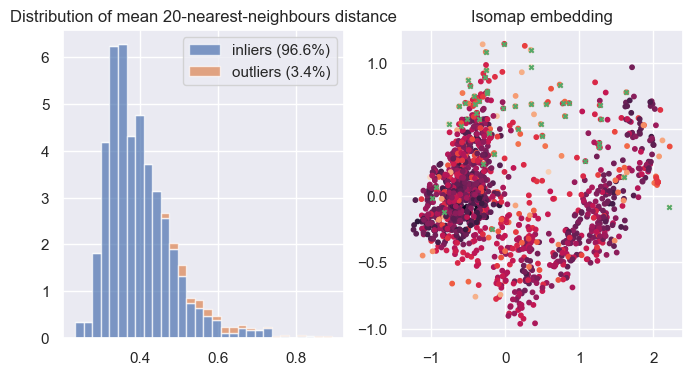

In [38]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8, 4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest-neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_speech.T, c=np.log10(score_speech), s=10)
axscat.scatter(*embedding_speech[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_speech) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_speech) * 100:.1f}%)'
]

axhist.hist([score_speech[outliers == 1], score_speech[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [39]:
df_speech = df_speech.loc[outliers == 1]
df_speech.shape

(1309, 250)

### Isolation forest on song dataframe

In [40]:
isfo = IsolationForest(max_samples=200)
outliers = isfo.fit_predict(X_song)

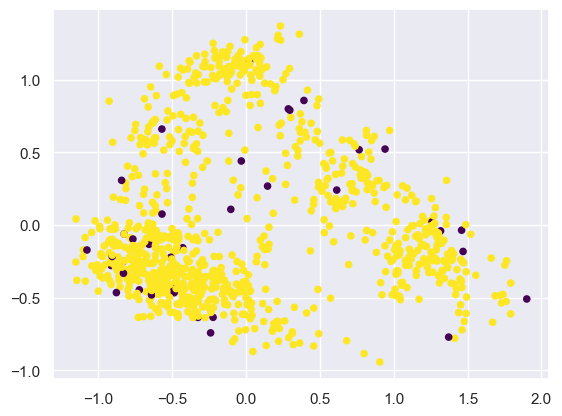

In [41]:
plt.scatter(*embedding_song.T, c=outliers, s=20, cmap='viridis')
plt.show()

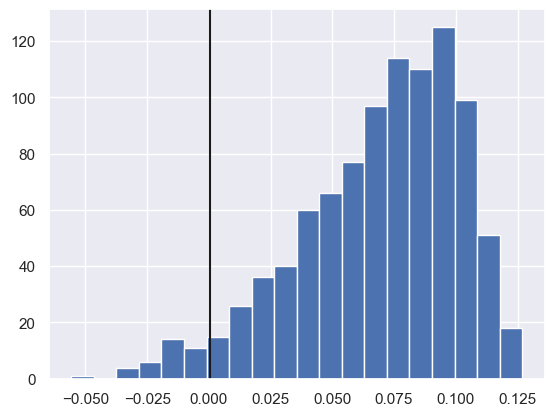

In [42]:
np.unique(outliers, return_counts=True)
plt.hist(isfo.decision_function(X_song), bins=20)
plt.axvline(np.min(isfo.decision_function(X_song)[np.where(outliers == 1)]), c='k')
plt.show()

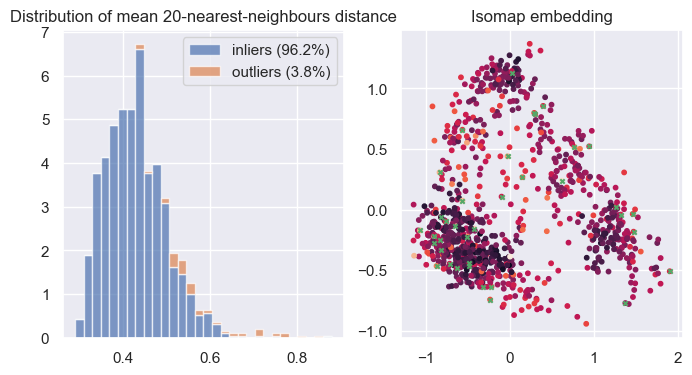

In [43]:
fig, (axhist, axscat) = plt.subplots(1, 2, figsize=(8, 4))

axhist.set_title(f'Distribution of mean {n_neighbors}-nearest-neighbours distance')
axscat.set_title('Isomap embedding')

axscat.scatter(*embedding_song.T, c=np.log10(score_song), s=10)
axscat.scatter(*embedding_song[outliers == -1].T, marker='x', color='g', s=10)

labels = [
    f'inliers ({np.sum(outliers == 1) / len(df_song) * 100:.1f}%)',
    f'outliers ({np.sum(outliers == -1) / len(df_song) * 100:.1f}%)'
]

axhist.hist([score_song[outliers == 1], score_song[outliers == -1]], bins=30,
            label=labels, density=True, stacked=True, alpha=0.7)

axhist.legend();

In [44]:
df_song = df_song.loc[outliers == 1]
df_song.shape

(933, 250)

### Elimination of the outliers found

In [45]:
# creates an index list by combining the indexes of the two dataframes
new_indexes = pd.Index(df_speech.index.tolist() + df_song.index.tolist())

# keep just the new indexes
df = df.loc[new_indexes]
df.shape

(2242, 250)

## Visualize the new dataset

In [46]:
normalized_df = (df[numerical_attr_list] - df[numerical_attr_list].min()) / (df[numerical_attr_list].max() - df[numerical_attr_list].min())

In [47]:
reducer = Isomap(n_neighbors=n_neighbors, p=10)
embedding = reducer.fit_transform(normalized_df)

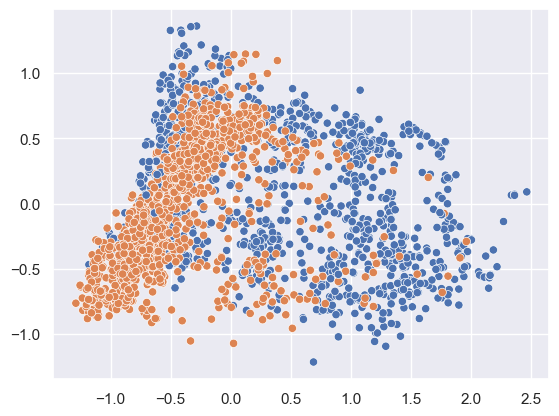

In [48]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['sex'], legend=False)
plt.show()

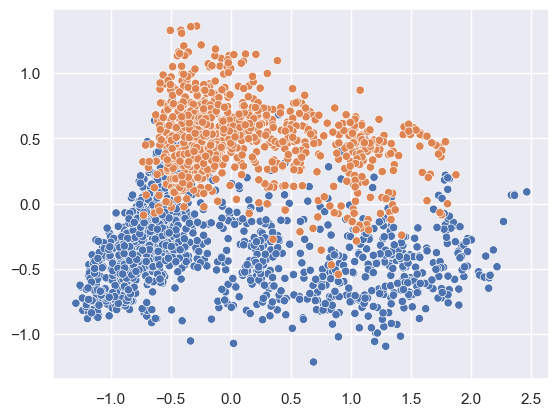

In [49]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['vocal_channel'], legend=False)
plt.show()

In [50]:
df = df.reset_index(drop=True)
#df.to_csv(NEW_DATASET, index=False)